In [1]:
import retinapy
import retinapy.spikeprediction as sp
import retinapy.mea as mea
import numpy as np
import torch
import pathlib
import matplotlib as mpl
import plotly
import plotly.graph_objects as go
import plotly.subplots as subplots
from collections import defaultdict
import retinapy.spikedistancefield as sdf
import torch.nn.functional as F
import scipy
import pathlib
import sklearn
import sklearn.metrics
import math
import pandas as pd
import cv2 as cv

In [2]:
def get_sample(ds, idx):
    """Don't forget how to get the samples as tensor tuples."""
    sample = torch.utils.data.dataloader.default_collate([ds[idx]])
    return sample

## Figures and stats, some functions

In [24]:
def kernel_plot(kernel, kernel_pad, bin_duration_ms):
    colormap = pd.DataFrame({
        'names':['Red', 'Green', 'UV', 'Blue', 'Stim'],
        'display_hex':['#ff0a0a', '#0aff0a', '#0a0aff', '#303030', '#0a0a0a']})
    fig = go.Figure()
    xs = (np.arange(kernel.shape[0]) - kernel.shape[0] + kernel_pad) * bin_duration_ms
    #fig.add_vline(x=-100, line_width=2, line_dash='dot', line_color='grey',
    #              annotation_text='-100ms', annotation_position='bottom right')
    for c in range(4):
        fig.add_trace(go.Scatter(x=xs, 
                                 y=kernel[:,c], 
                                 line_color=colormap.loc[c]['display_hex'], 
                                 mode='lines'))
    fig.update_layout(autosize=False,
                      height=400,
                      width=800,
                      margin=dict(l=1, r=1, b=1, t=25, pad=10),
                      yaxis_fixedrange=True,
                      showlegend=False,
                      title='Kernel',
                      title_x=0.5,
                      title_pad=dict(l=1, r=1, b=10, t=10),
                      xaxis={'title':'time (ms), with spike at 0'},
                      yaxis={'title':'Stimulus', 'range': [0,1]} )
    return fig

In [4]:
def print_stats(pred, actual):
    p,y  = pred, actual
    print(p.shape, y.shape)
    pearson_corr = scipy.stats.pearsonr(p, y)[0]
    pr = np.round(p)
    acc = np.mean(pr == y)
    cm = sklearn.metrics.confusion_matrix(y, pr)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    acc_2 = (TP + TN) / (TP + TN + FN + FP)
    assert acc_2 == acc
    recall = TP / (TP + FN)    # Out of all true 1s, how many are predicted as 1?
    precision = TP / (TP + FP) # Given a 1 prediction, what is the chance that it was a 1?
    print(f'pred 1s: {TP+FP}, actual 1s: {TP+FN}')
    print(f'acc: {acc:.4f}, pearson_corr: {pearson_corr:.4f}, '
          f'recall: {recall:.4f}, precision: {precision:.4f}')
    print(f'sklearn report:\n{sklearn.metrics.classification_report(y, pr)}')

## Load data and trained model

In [5]:
stimulus_pattern_path = "../data/ff_noise.h5"
stimulus_rec_path = "../data/ff_recorded_noise.pickle"
response_path = "../data/ff_spike_response.pickle"
rec_name = "Chicken_17_08_21_Phase_00"

rec = mea.single_3brain_recording(
    rec_name,
    mea.load_stimulus_pattern(stimulus_pattern_path),
    mea.load_recorded_stimulus(stimulus_rec_path),
    mea.load_response(response_path),
    include_clusters={21},
)

In [6]:
project_root = pathlib.Path("../")
out_dir = project_root / "out/demo/transformer_21/0"
out_dir = project_root / "out/demo/transformer_21_9ds/1"
model_ckpt = out_dir / "Transformer-18ds_992in/checkpoint_best_loss.pth"
model_ckpt = out_dir / "Transformer-9ds_3174in/checkpoint_best_loss.pth"
arg_file = out_dir / "args.yaml"
assert pathlib.Path(model_ckpt).resolve().exists()
assert pathlib.Path(arg_file).resolve().exists()

In [7]:
# Create datasets and model.
input_len = 3174
output_len = 400 
downsample = 9
opt = sp.args_from_yaml(arg_file)
opt.stride = 1
trainable = sp.TransformerTGroup.create_trainable([rec], sp.Configuration(downsample, input_len, output_len), 
                                          opt=opt)
retinapy.models.load_model(trainable.model, model_ckpt)
trainable.model.eval()
trainable.model.cuda();

In [8]:
test_ds = trainable.test_ds.datasets[0]
snippet_shape = test_ds[0]['snippet'].T.shape
print(snippet_shape)
snippet_len = snippet_shape[0]
print(f'Snippet shape: {snippet_shape}, input_len: {input_len}, output_len: {output_len}')
assert snippet_shape[0] == (input_len + output_len)

(3574, 5)
Snippet shape: (3574, 5), input_len: 3174, output_len: 400


## 1. Kernel via STA approach
The traditional STA approach to calculate kernels.

In [9]:
"""
 |---stimulus-----------|
 |-------------|-target-|
 |-------------|--400---|
 |-------------|-|pred|-|
0|         3174| |    | |
                 3    3  
                 2    4
                 7    7
                 4    4

"""
def whole_distfield(trainable, pred_len=200, pred_start=100, snippet_pad=600):
    with torch.no_grad():
        num_overlap = 2
        assert pred_len % num_overlap == 0
        step = pred_len // num_overlap
        _slice = (pred_start, pred_start + pred_len)
        summed = torch.zeros(size=(len(trainable.test_ds)+pred_len,), device='cpu')
        for i in range(0, len(trainable.test_ds), step):
            sample = get_sample(trainable.test_ds, i)
            model_out, _ = trainable.forward(sample)
            summed[i:i+pred_len] = model_out[0,pred_start:pred_start + pred_len].cpu()
        summed /= num_overlap
    # Urh. There is a prefix due to spike prediction happening after the 3174 bins that
    # are used for the input. Add in the offset for the fact that we are not taking the
    # whole model output, but a slice starting at pred_start. 
    prefix_len = test_ds.mask_slice.start + pred_start - 1
    suffix_len = output_len - (pred_len + pred_start) + snippet_pad
    #  150ms. Aiming for the average distance.
    pad_value_as_dist = 300 
    pad_value = trainable.distfield_to_nn_output(torch.Tensor([pad_value_as_dist])).item()
    dist = np.concatenate([
        np.full(shape=(prefix_len,), fill_value=pad_value),
        summed.numpy(),
        np.full(shape=(suffix_len,), fill_value=pad_value),
    ])
    return dist

def spike_prob(distfield):
    upshift = 0.5
    prob = torch.clamp(-distfield + upshift, min=0, max=3)
    return prob

def infer_spikes(dist, dist_threshold, grad_threshold):
    dist = _blur(dist, sigma=10.0)
    is_near_spike = (dist < dist_threshold)
    grad = np.gradient(dist)
    has_low_grad = (grad < grad_threshold)
    has_positive_grad2 = np.gradient(grad) > 0.00
    spikes = is_near_spike & has_low_grad & has_positive_grad2
    return spikes

def infer_spikes_via_spline(dist, dist_threshold, grad_threshold, smoothing=0):
    #spline = scipy.interpolate.InterpolatedUnivariateSpline(x=xs,  y=dist, k=4)#s=smoothing)
    downsample = 1
    dist_ds = scipy.signal.decimate(dist, downsample)
    xs = np.arange(len(dist_ds))
    spline = scipy.interpolate.UnivariateSpline(x=xs,  y=dist_ds, k=4, s=smoothing)
    roots_idxs = np.round(spline.derivative().roots()).astype(int)
    grad2_at_roots = spline.derivative().derivative()(roots_idxs)
    dist_at_roots = spline(roots_idxs)
    minima_idxs = roots_idxs[np.logical_and(grad2_at_roots > 0, 
                                            dist_at_roots < dist_threshold)] * downsample
    minima = np.zeros_like(dist)
    minima[minima_idxs] = 1
    return minima, spline
    grad = spline.derivative(n=1)(xs)
    grad2 = spline.derivative(n=2)(xs)
    is_near_spike = (spline(xs) < dist_threshold)
    is_near_local_extremum = (grad < grad_threshold)
    is_min = (grad2 > 0)
    spikes = is_near_spike & is_near_local_extremum & is_min
    return spikes, spline

def _blur(x, sigma):
    return scipy.ndimage.gaussian_filter1d(x, sigma=sigma, axis=0, mode='constant', cval=0.0)



def sta(trainable):
    test_ds = trainable.test_ds.datasets[0]
    threshold = 0
    pred_len = 200
    pred_start = 100
    snippet_pad = test_ds.pad
    print(f'len(test_ds): {len(test_ds)}')
    print(len(test_ds) + 1000 + input_len)
    print(len(test_ds.ds.recording.stimulus))
    #assert len(test_ds)+1000+input_len-1 == len(test_ds.ds.recording.stimulus)
    distfield = whole_distfield(trainable, pred_len, pred_start, snippet_pad)

    # Predicted spikes.
    pred_spikes, spline = infer_spikes_via_spline(distfield, dist_threshold=-0.9, grad_threshold=0.2)
    num_color_channels = 4
    #Actual spikes
    actual_spikes = test_ds.ds.recording.spikes[:,0]
    
    print_stats(pred=pred_spikes, actual=actual_spikes)
    pred_spike_idxs = np.squeeze(np.nonzero(pred_spikes))
    actual_spike_idxs = np.squeeze(np.nonzero(actual_spikes))
    stim =  test_ds.ds.recording.stimulus
    pred_spike_snippets = retinapy.mea.spike_snippets(stim, pred_spike_idxs, total_len=input_len+output_len, post_spike_len=output_len)
    actual_spike_snippets = retinapy.mea.spike_snippets(stim, actual_spike_idxs, total_len=input_len+output_len, post_spike_len=output_len)
    pred_kernel = np.mean(pred_spike_snippets, axis=0)
    actual_kernel = np.mean(actual_spike_snippets, axis=0)
    return pred_kernel, actual_kernel, distfield, pred_spikes

In [10]:
pred_kernel, actual_kernel, distfield, pred_spikes = sta(trainable)
pred_kernel_1ms = scipy.signal.decimate(pred_kernel, 2, axis=0)
actual_kernel_1ms = scipy.signal.decimate(actual_kernel, 2, axis=0)
kernel_pad_1ms = 200
bin_duration_ms = 1.008

len(test_ds): 173812
177986
178575
(178575,) (178575,)
pred 1s: 526, actual 1s: 733
acc: 0.9931, pearson_corr: 0.0175, recall: 0.0177, precision: 0.0247
sklearn report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    177842
           1       0.02      0.02      0.02       733

    accuracy                           0.99    178575
   macro avg       0.51      0.51      0.51    178575
weighted avg       0.99      0.99      0.99    178575



### 1.1 Results (the kernel)
The steps to calculate this kernel are:

    1. Use pretrained model to generate a distance field for the whole training data snippet.
    2. Try and guess the location of spikes based on the distance field created in 1. This is a very
        rudimentary heuristic approach to estimating the maximum likelihood spikes.
    3. Run the standard spike train analysis on the spikes from 2.

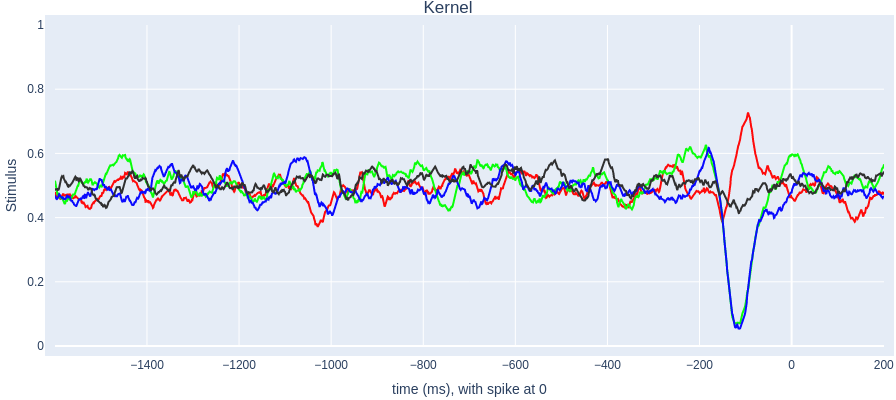

In [21]:
fig = kernel_plot(pred_kernel_1ms, kernel_pad=kernel_pad_1ms, bin_duration_ms=bin_duration_ms)
fig.write_image('../out/kernel_fake.svg')
fig

### 1.2 True STA kernel (from recorded spikes)
For comparison, here is the STA kernel calculated from recorded spikes.

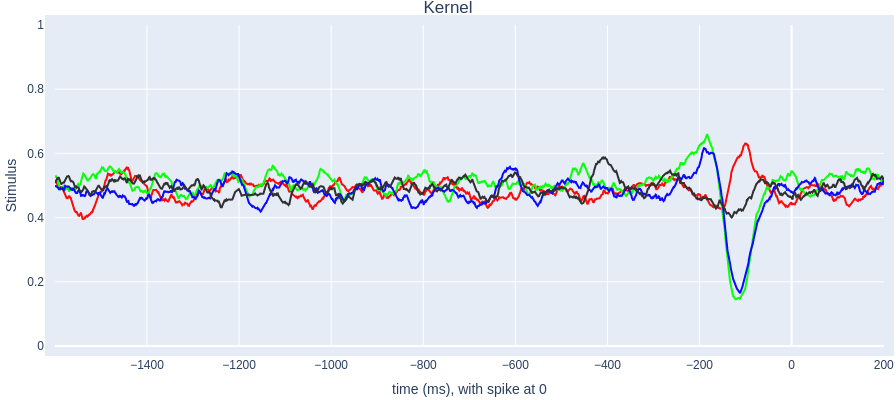

In [22]:
fig = kernel_plot(actual_kernel_1ms, kernel_pad=kernel_pad_1ms, bin_duration_ms=bin_duration_ms)
fig.write_image('../out/kernel_real.svg')
fig

### 1.3 Spike inference. Quality check

11


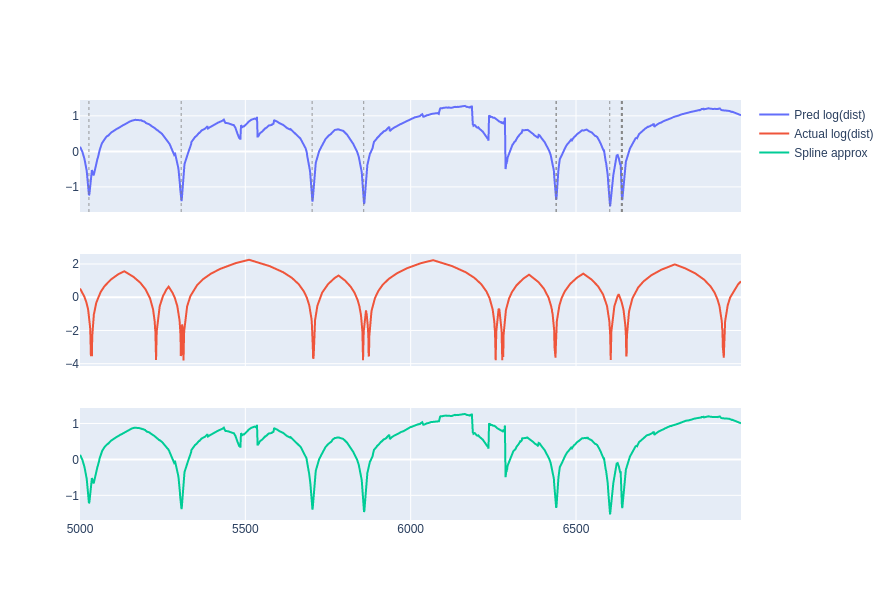

In [16]:
def _debug_spike_inference(pred_distfield, actual_distfield, start_ms=0, duration_ms=2000):
    downsample = 2
    pred_spikes, spline = infer_spikes_via_spline(pred_distfield, dist_threshold=-0.9, 
                                                  grad_threshold=0.1)
    xs_double_res = np.arange(duration_ms*downsample) + start_ms*downsample
    xs = np.arange(duration_ms) + start_ms
    spline_1ms = scipy.signal.decimate(spline(xs_double_res), downsample)
    pred_df_1ms = scipy.signal.decimate(pred_distfield, downsample, axis=0)
    actual_df_1ms = scipy.signal.decimate(actual_distfield, downsample, axis=0)
    spike_idxs = np.round(np.squeeze(np.nonzero(pred_spikes)).astype(float) / downsample)
    scatter_p = go.Scatter(x=xs, y=pred_df_1ms[start_ms:start_ms+duration_ms], 
                          name="Pred log(dist)")
    scatter_y = go.Scatter(x=xs, y=actual_df_1ms[start_ms:start_ms+duration_ms],
                          name="Actual log(dist)")
    scatter_s = go.Scatter(x=xs, y=spline_1ms,
                           name="Spline approx")
    fig = subplots.make_subplots(rows=3, cols=1, shared_xaxes=True) 
    fig.add_trace(scatter_p, row=1, col=1)
    fig.add_trace(scatter_y, row=2, col=1)
    fig.add_trace(scatter_s, row=3, col=1)
    fig.update_layout({
        "height": 600,
        "width": 800})
    spikes_in_xs = spike_idxs[np.logical_and(spike_idxs > start_ms, spike_idxs < start_ms + duration_ms)]
    #spikes_in_xs = np.squeeze(np.nonzero(pred_spikes[start_ms:start_ms+duration_ms])) + start_ms
    print(len(spikes_in_xs))
    if len(spikes_in_xs) < 100:
        for s in spikes_in_xs:
            fig.add_vline(x=s, line_width=0.8, line_dash='dot', line_color='grey', row=1, col=1)
    fig.show()
    fig.write_image("../out/spikes1.svg")

def debug_spike_inference(trainable, start_ms):
    pred_len = 200
    pred_start = 100
    snippet_pad = 600
    pred_distfield = whole_distfield(trainable, pred_len, pred_start, snippet_pad)
    max_dist = 600
    actual_distfield = sdf.distance_field(test_ds.ds.recording.spikes[:,0], max_dist)
    actual_distfield = trainable.distfield_to_nn_output(torch.Tensor(actual_distfield)).numpy()
    _debug_spike_inference(pred_distfield, actual_distfield, start_ms)
    
debug_spike_inference(trainable, start_ms=5000)

## 2. Kernel vias optimized input
Calculate the pseudo kernel by optimizing the input stimulus for a given model output.

Some inspiration for the training loop came from: https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/cnn_layer_visualization.py.


In [25]:
colormap = pd.DataFrame({
    'names':['Red', 'Green', 'UV', 'Blue', 'Stim'],
    'display_hex':['#ff0a0a', '#0aff0a', '#0a0aff', '#303030', '#0a0a0a']})

def kernel_plot2(kernel, snippet_pad, bin_duration_ms):
    fig = go.Figure()
    xs = (np.arange(kernel.shape[0]) - kernel.shape[0]) * bin_duration_ms
    # Shift the x-axis to have zero in the middle.
    xs += snippet_pad
    #fig.add_vline(x=-100, line_width=2, line_dash='dot', line_color='grey',
    #              annotation_text='-100ms', annotation_position='bottom right')
    for c in range(4):
        fig.add_trace(go.Scatter(x=xs, 
                                 y=kernel[:,c], 
                                 line_color=colormap.loc[c]['display_hex'], 
                                 mode='lines'))
    fig.update_layout(autosize=False,
                      height=400,
                      width=800,
                      margin=dict(l=1, r=1, b=1, t=25, pad=1),
                      yaxis_fixedrange=True,
                      showlegend=False,
                      title='Kernel',
                      title_x=0.5,
                      title_pad=dict(l=1, r=1, b=10, t=1),
                      xaxis={'title':'time (ms), with spike at 0'},
                      yaxis={'title':'Stimulus', 'range': [-2,3]} )
    return fig


def display_dist(model_out, y, downsample=2, loss_slice=None):
    y = scipy.signal.decimate(y, downsample)
    model_out = scipy.signal.decimate(model_out, downsample)
    xs = np.arange(len(y))
    fig = go.Figure()
    scatter_model = go.Scatter(x=xs, y=model_out, name='Pred', line_color='gray')
    fig.add_trace(scatter_model)
    scatter_y = go.Scatter(x=xs, y=y, name='Actual', line_color='red')
    fig.add_trace(scatter_y)
    if loss_slice:
        fig.add_vline(x=loss_slice.start//downsample, line_width=0.8, 
                      line_dash='dot', line_color='grey', row=1, col=1)
        fig.add_vline(x=loss_slice.stop//downsample, line_width=0.8, 
                      line_dash='dot', line_color='grey', row=1, col=1)
    fig.update_layout(height=400,
                      width=800,
                      title='Log distance field. Model (gray), actual (red)')
    return fig


torch.manual_seed(0)
def calc_kernel(trainable, num_steps=10, 
                spikes=None,
                loss_slice=None,
                mag_weight=0.01, freq_weight=0.01, cutoff_freq=None):
    trainable.model.eval()
    num_shifts = 5
    base_len = test_ds[0]['snippet'].shape[1] # 3574
    color_channels = 4
    total_stim_len = base_len + num_shifts
    input_stim = torch.normal(mean=0, std=2, size=(color_channels, total_stim_len), requires_grad=True, dtype=torch.float32, device='cuda')
    device = input_stim.device
    assert input_stim.shape[1] == base_len + num_shifts
    # Set the spike channel to zero.
    spike_history = torch.zeros(size=(1, total_stim_len), 
                                #requires_grad=True, 
                                device=device)
    spike_history[0, 3174:-1] = test_ds.MASK_VALUE
    # We can't enable grad before the stack, as it will be copied.
    # see: https://discuss.pytorch.org/t/variable-update-after-autograd-in-torch-cat-torch-vstack-nn-zeropad2d-torch-index-select-and-torch-roll/124823
    #input_stim = input_snippet[0,0:5,:]
    #input_stim.requires_grad_(True)
    optimizer = torch.optim.Adam([input_stim], lr=0.005, weight_decay=0)
    
    # Frequency reg.
    freq_bins = torch.fft.rfftfreq(total_stim_len, d=1/2231.596)
    #torch.zeros_like(freq_bins, device=device)
    if cutoff_freq:
        freq_penalty = torch.zeros_like(freq_bins, device=device)
        freq_penalty[torch.where(freq_bins > cutoff_freq)] = freq_weight
    else:
        freq_penalty = torch.arange(len(freq_bins), device=device)/len(freq_bins)
    
    
    loss_fn = torch.nn.MSELoss()
    def target_nn_output(spike_indicies, shift, length=400):
        spikes = np.zeros((length,))
        spikes[spike_indicies+shift] = 1
        df = retinapy.spikedistancefield.distance_field(spikes, default_distance=600)
        res = trainable.distfield_to_nn_output(torch.Tensor(df))
        res = torch.unsqueeze(res, 0).cuda()
        return res
    
    # Precompute the targets, as they don't change.
    targets = [target_nn_output(np.array(spikes), shift=-d, length=400) for d in range(num_shifts)]
    targets = torch.vstack(targets)
    for i in range(0, num_steps):
        optimizer.zero_grad()
        input_snippet = torch.stack(
            [torch.vstack([input_stim, torch.abs(spike_history)])[:,start:start+base_len] for start in range(num_shifts)])
        rec_id, c_id = (torch.Tensor([0,0,0,0,0]).long().cuda(), torch.Tensor([0,0,0,0,0]).long().cuda())
        model_out,_,_ = trainable.model(input_snippet, rec_id, c_id)
        model_loss = torch.sum(torch.norm((model_out - targets)[:,loss_slice], p=2, dim=1))
        loss = model_loss
        mag_loss = mag_weight * torch.sum(torch.norm(input_stim, p=1, dim=1))
        freq_loss = torch.norm(torch.fft.rfft(input_stim) * freq_penalty)
        #spike_loss = torch.sum(torch.abs(spike_history))
        #loss += spike_loss
        loss += mag_loss 
        loss += freq_loss
        loss.backward()
        optimizer.step()
        if (i+1) % 500 == 0:
            print(f'Loss. mag: {mag_loss}, freq: {freq_loss}, model: {model_loss}')
    res = input_stim[:,0:base_len].detach().cpu().numpy().T
    return res, targets.cpu(), (input_snippet.detach(), rec_id.detach(), c_id.detach())

def smooth(stimulus):
    # Bins are 0.5ms = 2000
    fs = 2000
    nyq = 0.5 * fs
    cutoff = 30
    b, a = scipy.signal.butter(3, cutoff/nyq)
    s = scipy.signal.filtfilt(b, a, stimulus, axis=0, method='gust')
    return s
    
def smooth_bl(stimulus):
    stimulus_ = np.expand_dims(stimulus,0)
    stimulus[:,0:3] = cv.bilateralFilter(stimulus_[:,:,0:3], d=0, sigmaColor=1, sigmaSpace=100)
    res = stimulus
    res[:,3] = 0
    return res

def blur(stimulus, sigma=10.0):
    return scipy.ndimage.gaussian_filter1d(stimulus, sigma=sigma, axis=0, mode='constant', cval=0.0)

def calc_and_display_opt_input():
    k, targets, last_inputs = calc_kernel(trainable, num_steps=1000)
    k_1ms = scipy.signal.decimate(k, 2, axis=0)
    #k_1ms = smooth(k)
    smooth_k = k_1ms
    smooth_k = blur(k_1ms)

    # 3574 (3174 + 400)
    fig = kernel_plot2(smooth_k, snippet_pad=400//2, bin_duration_ms=1.008)
    fig.show()
    model_out = trainable.model(last_inputs).detach().cpu().numpy()
    #fig = display_dist(model_out[0], targets[0].cpu().numpy())
    #fig.show()
    

Loss. mag: 0.0, freq: 0.0, model: 15.78752613067627
Loss. mag: 0.0, freq: 0.0, model: 14.380331039428711
Loss. mag: 0.0, freq: 0.0, model: 13.659300804138184
Loss. mag: 0.0, freq: 0.0, model: 13.139579772949219
Loss. mag: 0.0, freq: 0.0, model: 12.771661758422852
Loss. mag: 0.0, freq: 0.0, model: 12.580102920532227
Loss. mag: 0.0, freq: 0.0, model: 12.418802261352539
Loss. mag: 0.0, freq: 0.0, model: 12.249078750610352
Loss. mag: 0.0, freq: 0.0, model: 12.102703094482422
Loss. mag: 0.0, freq: 0.0, model: 11.969053268432617


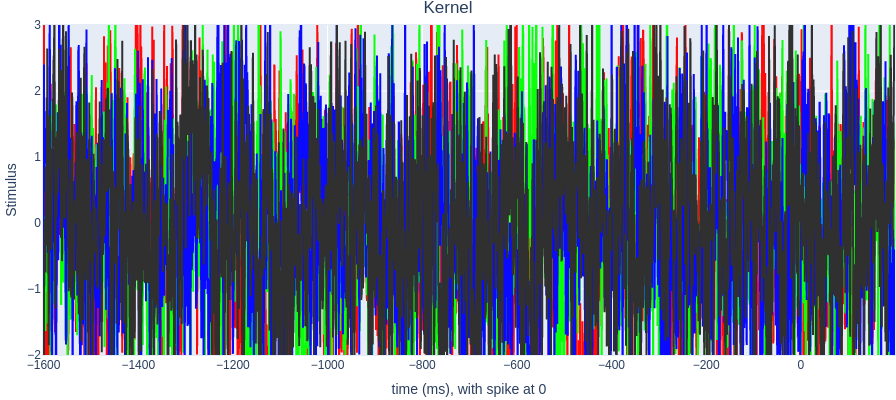

TypeError: forward() missing 2 required positional arguments: 'rec_id' and 'cluster_id'

In [35]:
num_trials = 3
ks = []
for t in range(num_trials):
    downsample = 2
    spikes = np.array([50])*downsample
    loss_slice=slice(0*downsample, 50*downsample)
    
    k, targets, last_inputs = calc_kernel(trainable, 
                                          num_steps=5000,
                                          spikes=spikes,
                                          loss_slice=loss_slice,
                                          mag_weight=0,#0.002,
                                          freq_weight=0,#0.02,
                                          cutoff_freq=100)
    
    k_1ms = scipy.signal.decimate(k, 2, axis=0)
    ks.append(k_1ms)
    fig = kernel_plot2(k_1ms, snippet_pad=400//2, bin_duration_ms=1.008)
    fig.show()
    fig.write_image('../out/MEI_no_reg.svg')
    model_out = trainable.model(last_inputs).detach().cpu().numpy()
    fig = display_dist(model_out[0], targets[0].cpu().numpy(), loss_slice=loss_slice, downsample=2)
    fig.show()
   

## Smoothed kernels

In [ ]:
for k in ks:
    fig = kernel_plot(blur(k, sigma=10), snippet_pad=200, bin_duration_ms=1.008)
    fig.show()

## Cluster 21 STA kernel
![Cluster 21 kernel](resources/cluster21_kernel.png)